In [1]:
from collections import defaultdict
import numpy as np
from copy import deepcopy
from matplotlib import pyplot as plt
from math import isclose
import cProfile
from multiprocessing import Pool

In [2]:
class State():
    def __init__(self, id_, actions):
        self.id = id_
        self.actions = actions
        
    def __repr__(self):
        return self.__str__()
        
    def __str__(self):
        return 'State(%d, %s)' % (self.id, self.actions)
        

class Action():
    def __init__(self, destinations, probabilities):
        assert len(destinations) == len(probabilities)
        assert isclose(sum(probabilities), 1)
        self.destinations = destinations
        self.probabilities = probabilities

    def __eq__(self, other):
        return self.destinations == other.destinations and self.probabilities == other.probabilities

    def __ne__(self, other):
        return not self.__eq__(other)
        
    def __repr__(self):
        return self.__str__()
        
    def __str__(self):
        return 'Action(%s)' % str([(self.destinations[i], ('%.2f' % self.probabilities[i])) for i in range(len(self.destinations))])
        
    def execute(self):
        next_state = np.random.choice(self.destinations, p=self.probabilities)
        return next_state
    

''' Directed State Action Graph (MDP without rewards) '''
class DSAG():
    def __init__(self, states):
        assert isinstance(states, list)
        assert all([len(state.actions) == len(states[0].actions) for state in states])
        self.states = states
        
    def convert_goal(self, goal):
        if isinstance(goal, (list, tuple)):
            goal = self.size*goal[0] + goal[1]
        return goal
        
    def show(self, goal=0, debug=False):
        goal = self.convert_goal(goal)
        value, policy = value_iterate(self, goal, debug=debug)
        
        for i_state, state in enumerate(self.states):
            print(i_state, state, value[i_state], policy[i_state])
        

class GridWorld(DSAG):
    def __init__(self, states):
        super().__init__(states)
        self.size = np.sqrt(len(states))
        assert int(self.size) == self.size
        self.size = int(self.size)
        
    def show(self, goal=0, gamma=.99, debug=False):
        goal = self.convert_goal(goal)
        value, policy = value_iterate(self, goal, gamma=gamma, debug=debug)
        
        print('Values:')
        plt.imshow(np.array(value).reshape(self.size, self.size))
        plt.show()
        
        print('Policy:')
        plt.imshow(np.array(policy).reshape(self.size, self.size))
        plt.show()
        
        print('key: wall, up, down, left, right')
        plt.imshow(np.array([-1,0,1,2,3]).reshape(1,5))
        
        if debug:
            print(np.array(policy).reshape(self.size, self.size))
            print(np.array(value).reshape(self.size, self.size))
            
    
class Taxi(DSAG):
    def __init__(self, states, indices):
        super().__init__(states)
        self.indices = indices
        self.size = indices.shape[0]
    
    def convert_goal(self, goal=(0,0), debug=False):
        return self.indices[goal[0], goal[1], goal[0], goal[1], 0]
    
    def show(self, passenger=(0,0), goal=(0,0), gamma=.99, debug=False):
        goal = self.convert_goal(goal)
        print(goal)
        value, policy = value_iterate(self, goal, gamma=gamma, debug=debug)
        
        rows = np.array(sum([[i]*self.size for i in range(self.size)], []))
        cols = np.concatenate([np.arange(self.size)]*self.size)
        
        print('Values:')
        print('Getting Passenger:')
        plt.imshow(np.array(value).reshape(self.size, self.size, self.size, self.size, 2)[:, :, passenger[0], passenger[1], 0])
        plt.show()
        print('Transporting Passenger:')
        plt.imshow(np.array(value).reshape(self.size, self.size, self.size, self.size, 2)[rows, cols, rows, cols, 1].reshape(self.size, self.size))
        plt.show()
        
        print('Policy:')
        print('Getting Passenger:')
        plt.imshow(np.array(policy).reshape(self.size, self.size, self.size, self.size, 2)[:, :, passenger[0], passenger[1], 0])
        plt.show()
        print('Transporting Passenger:')
        plt.imshow(np.array(policy).reshape(self.size, self.size, self.size, self.size, 2)[rows, cols, rows, cols, 1].reshape(self.size, self.size))
        plt.show()
        
        print('key: wall, up, down, left, right, pick, place')
        plt.imshow(np.array([-1,0,1,2,3,4,5]).reshape(1,7))
        
        if debug:
            print(np.array(value).reshape(self.size, self.size, self.size, self.size, 2)[:, :, passenger[0], passenger[1], 0])
            print(np.array(value).reshape(self.size, self.size, self.size, self.size, 2)[rows, cols, rows, cols, 1].reshape(self.size, self.size))
            print(np.array(policy).reshape(self.size, self.size, self.size, self.size, 2)[:, :, passenger[0], passenger[1], 0])
            print(np.array(policy).reshape(self.size, self.size, self.size, self.size, 2)[rows, cols, rows, cols, 1].reshape(self.size, self.size))

In [3]:
def get_adjacent_taxi(i_state, size, indices):
    adj = [i_state]
    
    ar = i_state // (size**3 * 2)
    ac = i_state // (size**2 * 2) % size
    pr = i_state // (size**1 * 2) % size
    pc = i_state // 2 % size
    h  = i_state % 2
    
    
    adj += [indices[max(ar-1, 0), ac, pr, pc, h]]
    adj += [indices[min(ar+1, size-1), ac, pr, pc, h]]
    adj += [indices[ar, max(ac-1, 0), pr, pc, h]]
    adj += [indices[ar, min(ac+1, size-1), pr, pc, h]]
    adj += [indices[ar, ac, max(pr-1, 0), pc, h]]
    adj += [indices[ar, ac, min(pr+1, size-1), pc, h]]
    adj += [indices[ar, ac, pr, max(pc-1, 0), h]]
    adj += [indices[ar, ac, pr, min(pc+1, size-1), h]]
    if h:
        adj += [indices[max(ar-1, 0), ac, max(pr-1, 0), pc, h]]
        adj += [indices[min(ar+1, size-1), ac, min(pr+1, size-1), pc, h]]
        adj += [indices[ar, max(ac-1, 0), pr, max(pc-1, 0), h]]
        adj += [indices[ar, min(ac+1, size-1), pr, min(pc+1, size-1), h]]
    adj += [indices[ar, ac, pr, pc, 0]]
    adj += [indices[ar, ac, pr, pc, 1]]
    
    return adj


def get_adjacent_gw(i_state, size):
    adj = [i_state]
    
    r = i_state // size
    c = i_state % size
    
    adj += [max(r-1, 0)*size + c]
    adj += [min(r+1, size-1)*size + c]
    adj += [max(c-1, 0) + r*size]
    adj += [min(c+1, size-1) + r*size]
    
    return adj


def get_adjacent(i_state, graph):
    if isinstance(graph, Taxi):
        return get_adjacent_taxi(i_state, graph.size, graph.indices)
    if isinstance(graph, GridWorld):
        return get_adjacent_gw(i_state, graph.size)
    else:
        raise Exception('Gotta use one of the above, bud.')


''' https://artint.info/html/ArtInt_227.html '''
def value_iterate(graph, goal_id, gamma=.99, epsilon=.001, debug=False):
    sz = graph.size
    if debug:
        pr = cProfile.Profile()
        pr.enable()
    value = [1] * len(graph.states)
    next_value = [0] * len(graph.states)
    policy = [-1] * len(graph.states)
    to_update = [abs(next_value[i] - value[i]) > epsilon for i in range(len(value))]
    iter = 0
    while any(to_update):
        value = deepcopy(next_value)
        for i_state, state in enumerate(graph.states):
            adj = get_adjacent(i_state, graph)
            if (any([to_update[ad] for ad in adj])) and (not (all([state.actions[0] == act for act in state.actions]))):
                action_value = [0] * len(state.actions)
                action_max = 0
                for i_action, action in enumerate(state.actions):
                    if all([dest == i_state for dest in action.destinations]):
                        continue
                    action_value[i_action] = sum([action.probabilities[i_sp]*((action.destinations[i_sp] == goal_id)+(1-(action.destinations[i_sp] == goal_id))*gamma*value[action.destinations[i_sp]]) for i_sp in range(len(action.destinations))])
                    if action_value[i_action] > action_max:
                        action_max = action_value[i_action]
                        policy[i_state] = i_action
                next_value[i_state] = action_max
        to_update = [abs(next_value[i] - value[i]) > epsilon for i in range(len(value))]
        
        if debug:
            iter += 1        
            print('=========')
            print(iter)
            print(sum(to_update))
    
    if debug:
        pr.disable()
        pr.print_stats()
    return next_value, policy

In [4]:
def build_gridworld(size, slip_rate=.1, walls=[], debug=False):
    states = [None]*size**2
    for i in range(size):
        for j in range(size):
            id_ = size*i+j
            up    = i-1
            down  = i+1
            left  = j-1
            right = j+1
            if (i, j) in walls:
                states[id_] = State(id_, [Action([size*i+j]*4, [1/4]*4)]*4)
            else:
                if i == 0 or (i-1, j) in walls:
                    up = i
                if i == (size-1) or (i+1, j) in walls:
                    down = i
                if j == 0 or (i, j-1) in walls:
                    left = j
                if j == (size-1) or (i, j+1) in walls:
                    right = j
                actions = [None]*4
                dests = [up*size+j, down*size+j, i*size+left, i*size+right]
                probs = [1-slip_rate, slip_rate/3]
                actions[0] = Action(dests, [probs[0], probs[1], probs[1], probs[1]])
                actions[1] = Action(dests, [probs[1], probs[0], probs[1], probs[1]])
                actions[2] = Action(dests, [probs[1], probs[1], probs[0], probs[1]])
                actions[3] = Action(dests, [probs[1], probs[1], probs[1], probs[0]])
                states[id_] = State(id_, actions)
            
                if debug:
                    print(i, j, [(dest//size, dest%size) for dest in actions[0].destinations])
                
    return GridWorld(states)


def build_four_rooms(size, slip_rate=.1, walls=[], debug=False):
    pos = size//2
    n_walls = [(pos, i) for i in range(size)] + [(i, pos) for i in range(size)]
    n_walls = n_walls[:-pos*3//2] + n_walls[-pos*3//2+1:]
    n_walls = n_walls[:-pos//2] + n_walls[-pos//2+1:]
    n_walls = n_walls[:pos*3//2] + n_walls[pos*3//2+1:]
    n_walls = n_walls[:pos//2] + n_walls[pos//2+1:]
    walls += n_walls
    
    if debug:
        print(walls)
        
    return build_gridworld(size, slip_rate, walls, debug)


def build_taxi(size, slip_rate=.1, walls=[], debug=False):
    indices = np.arange(size**4*2).reshape(size, size, size, size, 2)
    states = [None] * indices.size
    for ar in range(size):
        for ac in range(size):
            for pr in range(size):
                for pc in range(size):
                    for h in range(2):
                        id_ = indices[ar, ac, pr, pc, h]
                        invalid = (not (pr==ar and pc==ac)) and h
                        if (ar, ac) in walls or (pr, pc) in walls or invalid:
                            states[id_] = State(id_, [Action([id_]*6, [1/6]*6)]*6)
                        else:
                            pick  = 1 if all([pr==ar, pc==ac]) else 0
                            place = 0
                            up    = -1
                            down  = 1
                            left  = -1
                            right = 1
                            if ar == 0 or (ar+up, ac) in walls:
                                up = 0
                            if ar == (size-1) or (ar+down, ac) in walls:
                                down = 0
                            if ac == 0 or (ar, ac+left) in walls:
                                left = 0
                            if ac == (size-1) or (ar, ac+right) in walls:
                                right = 0
                            
                            aup    = ar+up
                            adown  = ar+down
                            aleft  = ac+left
                            aright = ac+right
                            if h:
                                pup    = pr+up
                                pdown  = pr+down
                                pleft  = pc+left
                                pright = pc+right
                            else:
                                pup    = pr
                                pdown  = pr
                                pleft  = pc
                                pright = pc
                            actions = [None]*6
                            dests = [indices[aup,   ac,     pup,   pc,     h], 
                                     indices[adown, ac,     pdown, pc,     h], 
                                     indices[ar,    aleft,  pr,    pleft,  h], 
                                     indices[ar,    aright, pr,    pright, h], 
                                     indices[ar,    ac,     pr,    pc,     pick], 
                                     indices[ar,    ac,     pr,    pc,     place]]
                            probs = [1-slip_rate, slip_rate/5]
                            actions = [Action(dests, [probs[1]]*i + [probs[0]] + [probs[1]]*(5-i)) for i in range(6)]
                            states[id_] = State(id_, actions)
                            
    return Taxi(states, indices)

In [5]:
a = build_gridworld(25, walls=[(i,i) for i in range(15)])

Values:


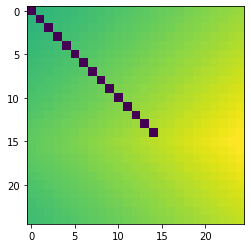

Policy:


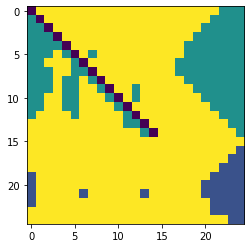

key: wall, up, down, left, right


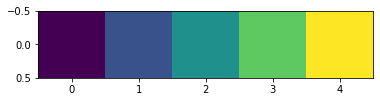

In [6]:
a.show(21*19, debug=False)

In [7]:
b = build_four_rooms(25, walls=[(i,i) for i in range(22)])

Values:


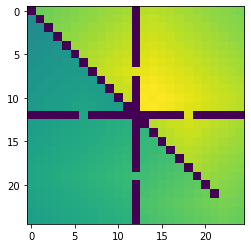

Policy:


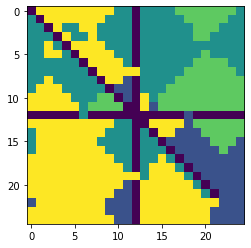

key: wall, up, down, left, right


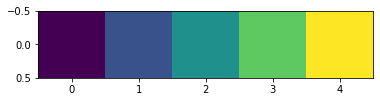

In [8]:
b.show((10, 14), debug=False)

In [9]:
c = build_taxi(10, slip_rate=.1, walls=[(2, i) for i in range(7)]+[(i+3, 6) for i in range(4)], debug=False)

0
Values:
Getting Passenger:


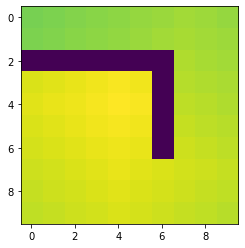

Transporting Passenger:


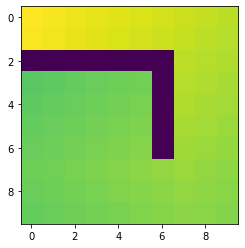

Policy:
Getting Passenger:


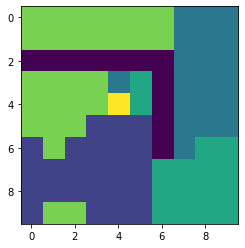

Transporting Passenger:


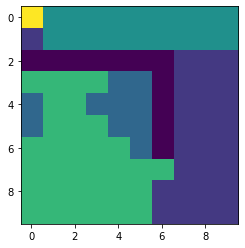

key: wall, up, down, left, right, pick, place


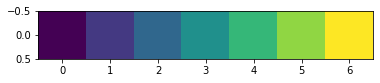

In [10]:
c.show(passenger=(4,4), goal=(0,0), debug=False)